<h1 align=center><font size = 6>Clustering Neighborhoods in Burlington</font></h1>

## Applied Data Science Capstone by IBM/Coursera

## Introduction 


In this project, the neighborhoods of Burlington (Ontario), the average house price in each neighborhood, and the list of schools for each neighborhood are scraped from  https://burlingtonneighbourhoods.com/ using BeautifulSoup library. School performance scores by Fraser Institute for each school are scraped from https://www.compareschoolrankings.org/. The parks, playgrounds, and sports fields of each neighborhood are searched from FourSquare API and shown on a Folium map. The neighborhoods of Burlington are grouped into 4 clusters based on the school performance scores and house prices, using the k_means clustering algorithm. 

## Table of Contents


<font size = 3>

1. <a href='#item1'>Neighborhood Locations</a>

2. <a href="#item2">Schools</a>

3. <a href="#item3">Houses</a>

4. <a href="#item4">Parks</a>

5. <a href="#item5">Clustering the Neighborhoods</a>    
</font>


In [1]:
import numpy as np 

import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json 

import requests 
from pandas.io.json import json_normalize 

import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

import folium 

import matplotlib.pyplot as plt


<a id='item1'></a>
## 1. Neighborhood Locations 

The locations of neighborhoods of Burlington shown on the map of Burlington in https://burlingtonneighbourhoods.com/map-of-burlington/ are manually extracted using Google Maps and saved into Neighborhoods.xlsx file.

In [2]:
Neighborhoods = pd.read_excel('Neighborhoods.xlsx')

In [3]:
Neighborhoods

,Neighborhood,Latitude,Longitude
0,Aldershot,43.312147,-79.859771
1,Alton Village,43.408200,-79.814130
2,Brant Hills,43.366230,-79.839933
3,Dynes,43.352015,-79.786079
4,Elizabeth Gardens,43.369097,-79.739184
5,Headon Forest,43.378287,-79.822473
6,Longmoor,43.366607,-79.770717
7,Millcroft,43.392882,-79.806383
8,Mountainside,43.352641,-79.820780
9,The Orchard,43.407001,-79.790942


In [4]:
# Burlington Location
latitude = 43.35
longitude = -79.7990

# create map
Burlington_Neighborhoods = folium.Map(location=[latitude, longitude], zoom_start=12)


# add markers to the map
for lat, lon, Neighborhood in zip(Neighborhoods['Latitude'], Neighborhoods['Longitude'], Neighborhoods['Neighborhood']):
    label = folium.Popup(str(Neighborhood))
    folium.Marker(
        [lat, lon],
        radius=5,
        popup=label).add_to(Burlington_Neighborhoods)
       
Burlington_Neighborhoods

<a id='item2'></a>
## 2. Schools

### Scraping the list of schools of each neighborhood

 Reference: https://burlingtonneighbourhoods.com/neighbourhoods/

In [5]:
from requests import get
url = 'https://burlingtonneighbourhoods.com/neighbourhoods/'
response = get(url)
print(response.text[0:500])

<!doctype html>
<html lang="en-US">
  <head>
  <meta charset="utf-8">
  <meta http-equiv="x-ua-compatible" content="ie=edge">
  <meta name="viewport" content="width=device-width, initial-scale=1, shrink-to-fit=no">
  <link rel="dns-prefetch" href="//player.vimeo.com">

  
	<!-- This site is optimized with the Yoast SEO plugin v14.9 - https://yoast.com/wordpress/plugins/seo/ -->
	<title>Burlington Neighbourhoods - Homes for Sale/Stats/Photos &amp; Local Schools</title>
	<meta name="description" c


In [6]:
from bs4 import BeautifulSoup
html_soup = BeautifulSoup(response.text, 'html.parser')
type(html_soup)

bs4.BeautifulSoup

In [7]:
html_soup.find('ul', class_ = 'sub-menu').find_all('li')

[<li class="nav-item u-header__nav-item menu-item menu-aldershot"><a href="https://burlingtonneighbourhoods.com/neighbourhood/aldershot/">Aldershot</a></li>,
 <li class="nav-item u-header__nav-item menu-item menu-alton-village"><a href="https://burlingtonneighbourhoods.com/neighbourhood/alton-village/">Alton Village</a></li>,
 <li class="nav-item u-header__nav-item menu-item menu-brant-hills"><a href="https://burlingtonneighbourhoods.com/neighbourhood/brant-hills/">Brant Hills</a></li>,
 <li class="nav-item u-header__nav-item menu-item menu-central-downtown-burlington"><a href="https://burlingtonneighbourhoods.com/neighbourhood/central/">Central (Downtown Burlington)</a></li>,
 <li class="nav-item u-header__nav-item menu-item menu-corporate"><a href="https://burlingtonneighbourhoods.com/neighbourhood/corporate/">Corporate</a></li>,
 <li class="nav-item u-header__nav-item menu-item menu-dynes"><a href="https://burlingtonneighbourhoods.com/neighbourhood/dynes/">Dynes</a></li>,
 <li class

Here is the list of links to the pages that contains the list of schools for each neighborhood. 

In [8]:
Links_list=[]

for i in range(0, 20):
    Links_list.append(html_soup.find('ul', class_ = 'sub-menu').find_all('li')[i].find('a').get('href'))
    
Links_list  

['https://burlingtonneighbourhoods.com/neighbourhood/aldershot/',
 'https://burlingtonneighbourhoods.com/neighbourhood/alton-village/',
 'https://burlingtonneighbourhoods.com/neighbourhood/brant-hills/',
 'https://burlingtonneighbourhoods.com/neighbourhood/central/',
 'https://burlingtonneighbourhoods.com/neighbourhood/corporate/',
 'https://burlingtonneighbourhoods.com/neighbourhood/dynes/',
 'https://burlingtonneighbourhoods.com/neighbourhood/elizabeth-gardens/',
 'https://burlingtonneighbourhoods.com/neighbourhood/headon-forest/',
 'https://burlingtonneighbourhoods.com/neighbourhood/longmoor/',
 'https://burlingtonneighbourhoods.com/neighbourhood/millcroft/',
 'https://burlingtonneighbourhoods.com/neighbourhood/mountainside/',
 'https://burlingtonneighbourhoods.com/neighbourhood/palmer/',
 'https://burlingtonneighbourhoods.com/neighbourhood/pinedale/',
 'https://burlingtonneighbourhoods.com/neighbourhood/plains/',
 'https://burlingtonneighbourhoods.com/neighbourhood/roseland/',
 'ht

In [9]:
Neighborhood = []
Schools = []


for link in Links_list:
    response = get(link)
    html_soup = BeautifulSoup(response.text, 'html.parser')
    Neighborhood.append(html_soup.title.text.split(':')[0])
    try:
        Schools.append([e for e in html_soup.find_all('div', class_ = 'col-lg-10 offset-lg-1 mb-9 mb-lg-0')[1].text.split('\n') if e][:-1])
    except ValueError:
        Schools.append([e for e in html_soup.find_all('div', class_ = 'col-md-6')[0].text.split('\n') if e][:-1])
        
    

In [10]:
Neighborhood

['Aldershot',
 'Alton Village',
 'Brant Hills',
 'Central (Downtown Burlington)',
 'Corporate',
 'Dynes ',
 'Elizabeth Gardens',
 'Headon Forest',
 'Longmoor',
 'Millcroft',
 'Mountainside',
 'Palmer',
 'Pinedale',
 'Plains',
 'Roseland',
 'Rural Burlington',
 'Shoreacres',
 'Tansley',
 'The Orchard',
 'Tyandaga']

Because of inconsistency in the exact name of schools on this website and the one that will be used later to scrape the school performance scores, we filter some words from the name of schools.  

In [11]:
Filter={'.':'', 'School': '', 'Elementary': '', 'Secondary': '', 'High': '', 'Public': '', 'Catholic': ''}

import copy

Filtered_Schools = copy.deepcopy(Schools)
for i in range (0,len(Filtered_Schools)):
    for j in range(0, len(Filtered_Schools[i])):
               
        for word in Filter:
            Filtered_Schools[i][j] = Filtered_Schools[i][j].replace(word, Filter[word])
            Filtered_Schools[i][j] = Filtered_Schools[i][j].split('(')[0].rstrip()
    
    

Because of inconsistency in the exact name of schools on this website and the one that will be used later to scrape the school performance scores, some edits are applied here. 

In [12]:
Edit_Dict={'MM Robinson': 'M M Robinson', 'St Timothy’s': 'St Timothy', 'Sir E MacMillan': 'Sir Ernest Macmillan', 'Alexander’s': "Alexander's"}

Filtered_Schools_Modified = copy.deepcopy(Filtered_Schools)

for i in range (0,len(Filtered_Schools_Modified)):
    for j in range(0, len(Filtered_Schools_Modified[i])):
        for Edit in Edit_Dict:
            Filtered_Schools_Modified[i][j] = Filtered_Schools_Modified[i][j].replace(Edit, Edit_Dict[Edit])
 

In [13]:
Neighborhood_Schools_Filtered_Modified = {Neighborhood[i]: Filtered_Schools_Modified[i] for i in range(len(Filtered_Schools_Modified))}
Neighborhood_Schools_Filtered_Modified

{'Aldershot': ['Glenview',
  'Maplehurst',
  'Kings Road',
  'Holy Rosary',
  'Aldershot',
  'Assumption'],
 'Alton Village': ['Alton Village',
  'St Anne',
  'Dr Frank J Hayden',
  'Corpus Christi'],
 'Brant Hills': ['Paul A Fisher',
  'Bruce T Lindley',
  'Brant Hills',
  'St Mark',
  'M M Robinson'],
 'Central (Downtown Burlington)': ['Tom Thomson',
  'Central',
  'Lakeshore',
  'St John',
  'Central',
  'Assumption'],
 'Corporate': ['John William Boich',
  'St Elizabeth Seton',
  'Dr Frank J Hayden',
  'Corpus Christi',
  'For more detailed information on these Corporate schools, visit our schools page'],
 'Dynes ': ['Ryerson', 'Tecumseh', 'St Paul', 'Assumption'],
 'Elizabeth Gardens': ['Mohawk Gardens',
  'St Patrick',
  'Pineland',
  'Robert Bateman',
  'Nelson',
  'Ascension'],
 'Headon Forest': ['C H Norton',
  'St Timothy',
  'Florence Meares',
  'Dr Frank J Hayden',
  'M M Robinson',
  'Notre Dame'],
 'Longmoor': ['Pauline Johnson',
  'John T Tuck',
  'Pineland',
  'St Rapha

### Scraping the Rating of each school 

 Reference: https://www.compareschoolrankings.org/

 On the website above, the list of all the schools in Burlington is searched and the pages of results are saved as html files. 

#### Elementery Schools 

In [15]:
FI_Report_Elementy=open('FI_Ranking_Elementry.html')

In [16]:
from bs4 import BeautifulSoup
html_soup_Elementy = BeautifulSoup(FI_Report_Elementy, 'html.parser')
type(html_soup_Elementy)

bs4.BeautifulSoup

In [17]:
SchoolList=[]
RatingList=[]

for i in range(2,44):
    SchoolName=html_soup_Elementy.find_all('table', class_='v-datatable v-table theme--light')[1].find_all('tr')[i].find('a', class_='school-name label').text.strip()
    SchoolList.append(SchoolName)
    try:
        Rating_1=html_soup_Elementy.find_all('table', class_='v-datatable v-table theme--light')[1].find_all('tr')[i].find('div', class_='flex xs6 text-xs-right field score_color_1').text
        RatingList.append(Rating_1)
    except:
        try:
            Rating_2=html_soup_Elementy.find_all('table', class_='v-datatable v-table theme--light')[1].find_all('tr')[i].find('div', class_='flex xs6 text-xs-right field score_color_2').text
            RatingList.append(Rating_2)
        except:
            try:
                Rating_3=html_soup_Elementy.find_all('table', class_='v-datatable v-table theme--light')[1].find_all('tr')[i].find('div', class_='flex xs6 text-xs-right field score_color_3').text
                RatingList.append(Rating_3)
            except:
                Rating_4=html_soup_Elementy.find_all('table', class_='v-datatable v-table theme--light')[1].find_all('tr')[i].find('div', class_='flex xs6 text-xs-right field score_color_4').text
                RatingList.append(Rating_4)
            

#### Secondary Schools 

In [18]:
FI_Report_Secondary=open('FI_Ranking_Secondary.html')

In [19]:
from bs4 import BeautifulSoup
html_soup_Secondary = BeautifulSoup(FI_Report_Secondary, 'html.parser')
type(html_soup_Secondary)

bs4.BeautifulSoup

In [20]:
for i in range(2,11):
    SchoolName=html_soup_Secondary.find_all('table', class_='v-datatable v-table theme--light')[1].find_all('tr')[i].find('a', class_='school-name label').text.strip()
    SchoolList.append(SchoolName)
    try:
        Rating_1=html_soup_Secondary_soup.find_all('table', class_='v-datatable v-table theme--light')[1].find_all('tr')[i].find('div', class_='flex xs6 text-xs-right field score_color_1').text
        RatingList.append(Rating_1)
    except:
        try:
            Rating_2=html_soup_Secondary.find_all('table', class_='v-datatable v-table theme--light')[1].find_all('tr')[i].find('div', class_='flex xs6 text-xs-right field score_color_2').text
            RatingList.append(Rating_2)
        except:
            try:
                Rating_3=html_soup_Secondary.find_all('table', class_='v-datatable v-table theme--light')[1].find_all('tr')[i].find('div', class_='flex xs6 text-xs-right field score_color_3').text
                RatingList.append(Rating_3)
            except:
                Rating_4=html_soup_Secondary.find_all('table', class_='v-datatable v-table theme--light')[1].find_all('tr')[i].find('div', class_='flex xs6 text-xs-right field score_color_4').text
                RatingList.append(Rating_4)
            

The school names are filtered for consistancy with the data scraped in section 3.1.

In [21]:
SchoolList_Filtered=copy.deepcopy(SchoolList)
Filter={'.':'', 'School': '', 'Elementary': '', 'Secondary': '', 'High': '', 'Public': '', "(Burlington)": '', 'Catholic': ''}

for i in range(0, len(SchoolList_Filtered)):
    for word in Filter:
        SchoolList_Filtered[i] = SchoolList_Filtered[i].replace(word, Filter[word])
    SchoolList_Filtered[i] = SchoolList_Filtered[i].rstrip()  

In [22]:
for i in range(0, len(RatingList)):
    RatingList[i]=float(RatingList[i])

In [23]:
School_Rating_Dict={}

for i in range(0, len(SchoolList_Filtered)):
    School_Rating_Dict[SchoolList_Filtered[i]]=RatingList[i]

Creating a dictionary containing the Fraser Institute (FI) rating of each school in Burlington. 

In [24]:
School_Rating_Dict_Modified = copy.deepcopy(School_Rating_Dict)
School_Rating_Dict_Modified['Kilbride'] = 5.5

School_Rating_Dict_Modified

{"Alexander's": 7.3,
 'Alton Village': 7.9,
 'Ascension': 7.3,
 'Brant Hills': 3.7,
 'Bruce T Lindley': 6.0,
 'C H Norton': 7.7,
 'Canadian Martyrs': 7.7,
 'Central': 6.6,
 'Charles R Beaudoin': 8.1,
 'Clarksdale': 6.5,
 'Florence Meares': 6.7,
 'Frontenac': 6.3,
 'Glenview': 6.7,
 'Holy Rosary': 5.3,
 'John T Tuck': 8.8,
 'John William Boich': 7.3,
 'Kings Road': 4.1,
 'Lakeshore': 6.1,
 'Maplehurst': 6.5,
 'Mohawk Gardens': 4.4,
 'Orchard Park': 7.6,
 'Paul A Fisher': 8.1,
 'Pauline Johnson': 4.2,
 'Pineland': 7.7,
 'Rolling Meadows': 6.7,
 'Ryerson': 7.3,
 'Sacred Heart of Jesus': 7.5,
 'Sir Ernest Macmillan': 6.0,
 'St Anne': 8.7,
 'St Christopher': 8.0,
 'St Elizabeth Seton': 5.8,
 'St Gabriel': 6.4,
 'St John': 6.4,
 'St Mark': 5.6,
 'St Patrick': 5.2,
 'St Paul': 6.6,
 'St Raphael': 8.1,
 'St Timothy': 7.8,
 'Tecumseh': 4.9,
 'Tom Thomson': 7.2,
 'Ã‰cole Ã©lÃ©mentaire Renaissance': 8.1,
 'Ã‰Ã‰C Saint-Philippe': 5.6,
 'Aldershot': 7.0,
 'Assumption': 6.3,
 'Burlington Central': 6

#### Calculating the school rating statistics for each neighborhood 

In [25]:
Rating_Dictionary = copy.deepcopy(Neighborhood_Schools_Filtered_Modified)

for Neighborhood in Rating_Dictionary:
    for i in range(0,len(Rating_Dictionary.get(Neighborhood))):
        try:
            Rating_Dictionary[Neighborhood][i] = School_Rating_Dict_Modified[Neighborhood_Schools_Filtered_Modified.get(Neighborhood)[i]]
        except:
            Rating_Dictionary[Neighborhood][i] = str('Rating Not Available')


Rating_Dictionary

{'Aldershot': [6.7, 6.5, 4.1, 5.3, 7.0, 6.3],
 'Alton Village': [7.9, 8.7, 7.4, 7.6],
 'Brant Hills': [8.1, 6.0, 3.7, 5.6, 6.0],
 'Central (Downtown Burlington)': [7.2, 6.6, 6.1, 6.4, 6.6, 6.3],
 'Corporate': [7.3, 5.8, 7.4, 7.6, 'Rating Not Available'],
 'Dynes ': [7.3, 4.9, 6.6, 6.3],
 'Elizabeth Gardens': [4.4, 5.2, 7.7, 6.6, 7.6, 7.3],
 'Headon Forest': [7.7, 7.8, 6.7, 7.4, 6.0, 7.0],
 'Longmoor': [4.2, 8.8, 7.7, 8.1, 7.6, 6.3],
 'Millcroft': [8.1, 6.7, 7.5, 7.4, 7.6],
 'Mountainside': [6.5, 7.8, 6.7, 6.4, 6.0, 7.0],
 'Palmer': [7.7, 'Rating Not Available', 6.0, 6.5, 6.0, 7.0],
 'Pinedale': [6.3, 7.3, 7.7, 6.6, 6.3],
 'Plains': [7.2, 4.9, 6.6, 6.4, 6.4, 6.6, 6.3],
 'Roseland': [8.8, 7.7, 8.1, 6.6, 7.6, 6.3],
 'Rural Burlington': [5.5, 6.0, 6.7, 6.4, 7.4, 6.0, 7.0],
 'Shoreacres': [8.8, 4.4, 7.7, 8.1, 7.6, 6.3],
 'Tansley': ['Rating Not Available', 6.5, 7.7, 6.0, 7.0],
 'The Orchard': [7.3, 7.6, 7.3, 5.8, 8.0, 7.4, 7.6],
 'Tyandaga': [6.5, 8.1, 6.5, 5.6, 6.4, 7.0, 6.0, 7.0]}

The FI score for 'Dr Charles Best' was not available. Therefore, it was removed from the data.

In [26]:
Rating_Dictionary_Cleaned=copy.deepcopy(Rating_Dictionary)

for key in Rating_Dictionary_Cleaned.keys():
    try:
        Rating_Dictionary_Cleaned[key].remove('Rating Not Available')
    except:
        pass
    

In [27]:
import statistics


Rating_Dictionary_Cleaned_Copy=copy.deepcopy(Rating_Dictionary_Cleaned )
Neighborhood_Name = []
School_Rating_ave = []
School_Rating_min = []
School_Rating_max = []

for key in Rating_Dictionary_Cleaned_Copy.keys():
    Neighborhood_Name.append(key)
    School_Rating_ave.append(round(statistics.mean(Rating_Dictionary_Cleaned_Copy.get(key)),1))
    School_Rating_min.append(min(Rating_Dictionary_Cleaned_Copy.get(key)))
    School_Rating_max.append(max(Rating_Dictionary_Cleaned_Copy.get(key)))
    
    
School_Rating = pd.DataFrame({'Neighborhood': Neighborhood_Name, 'Average FI Score': School_Rating_ave, 'Maximum FI Score': School_Rating_max, 'Minimum FI Score': School_Rating_min})
School_Rating

,Neighborhood,Average FI Score,Maximum FI Score,Minimum FI Score
0,Aldershot,6.0,7.0,4.1
1,Alton Village,7.9,8.7,7.4
2,Brant Hills,5.9,8.1,3.7
3,Central (Downtown Burlington),6.5,7.2,6.1
4,Corporate,7.0,7.6,5.8
5,Dynes,6.3,7.3,4.9
6,Elizabeth Gardens,6.5,7.7,4.4
7,Headon Forest,7.1,7.8,6.0
8,Longmoor,7.1,8.8,4.2
9,Millcroft,7.5,8.1,6.7


The name of Dynes neighborhood was edited for consistency with the other data.

In [28]:
School_Rating['Neighborhood'] = School_Rating['Neighborhood'].replace('Dynes ', 'Dynes')

In [29]:
School_Rating.describe()

,Average FI Score,Maximum FI Score,Minimum FI Score
count,20.000000,20.000000,20.000000
mean,6.800000,7.875000,5.505000
std,0.523148,0.555238,0.970879
min,5.900000,7.000000,3.700000
25%,6.475000,7.550000,4.775000
50%,6.750000,7.750000,5.800000
75%,7.125000,8.100000,6.025000
max,7.900000,8.800000,7.400000


The standard deviation for 'Minimum FI Score' data is about twice of the standard deviation of 'Average FI Score' data. Therefore, a new parameter, (Average_Score)X(min_Score), was defined to be used in clustering of the neighborhoods. Use of this parameter instead of using only the 'Average FI Score' would better distinguish the distribution of school performance scores for each neighborhood. 

In [30]:
School_Rating['(Average_Score)X(min_Score)']=School_Rating['Average FI Score']*School_Rating['Minimum FI Score']
School_Rating.set_index('Neighborhood', inplace=True)

In [31]:
School_Rating

,Average FI Score,Maximum FI Score,Minimum FI Score,(Average_Score)X(min_Score)
Neighborhood,,,,
Aldershot,6.0,7.0,4.1,24.60
Alton Village,7.9,8.7,7.4,58.46
Brant Hills,5.9,8.1,3.7,21.83
Central (Downtown Burlington),6.5,7.2,6.1,39.65
Corporate,7.0,7.6,5.8,40.60
Dynes,6.3,7.3,4.9,30.87
Elizabeth Gardens,6.5,7.7,4.4,28.60
Headon Forest,7.1,7.8,6.0,42.60
Longmoor,7.1,8.8,4.2,29.82


<a id='item3'></a>
## 3. Houses 

### Scraping the House Price Data <a name="4.1"></a>
 Reference: https://burlingtonneighbourhoods.com/neighbourhoods/

In [32]:
url = 'https://burlingtonneighbourhoods.com/neighbourhoods/'
response = get(url)
print(response.text[0:500])

<!doctype html>
<html lang="en-US">
  <head>
  <meta charset="utf-8">
  <meta http-equiv="x-ua-compatible" content="ie=edge">
  <meta name="viewport" content="width=device-width, initial-scale=1, shrink-to-fit=no">
  <link rel="dns-prefetch" href="//player.vimeo.com">

  
	<!-- This site is optimized with the Yoast SEO plugin v14.9 - https://yoast.com/wordpress/plugins/seo/ -->
	<title>Burlington Neighbourhoods - Homes for Sale/Stats/Photos &amp; Local Schools</title>
	<meta name="description" c


In [33]:
html_soup = BeautifulSoup(response.text, 'html.parser')
type(html_soup)

bs4.BeautifulSoup

In [34]:
html_soup.find('ul', class_ = 'sub-menu').find_all('li')

[<li class="nav-item u-header__nav-item menu-item menu-aldershot"><a href="https://burlingtonneighbourhoods.com/neighbourhood/aldershot/">Aldershot</a></li>,
 <li class="nav-item u-header__nav-item menu-item menu-alton-village"><a href="https://burlingtonneighbourhoods.com/neighbourhood/alton-village/">Alton Village</a></li>,
 <li class="nav-item u-header__nav-item menu-item menu-brant-hills"><a href="https://burlingtonneighbourhoods.com/neighbourhood/brant-hills/">Brant Hills</a></li>,
 <li class="nav-item u-header__nav-item menu-item menu-central-downtown-burlington"><a href="https://burlingtonneighbourhoods.com/neighbourhood/central/">Central (Downtown Burlington)</a></li>,
 <li class="nav-item u-header__nav-item menu-item menu-corporate"><a href="https://burlingtonneighbourhoods.com/neighbourhood/corporate/">Corporate</a></li>,
 <li class="nav-item u-header__nav-item menu-item menu-dynes"><a href="https://burlingtonneighbourhoods.com/neighbourhood/dynes/">Dynes</a></li>,
 <li class

In [35]:
Links_list=[]

for i in range(0, 20):
    Links_list.append(html_soup.find('ul', class_ = 'sub-menu').find_all('li')[i].find('a').get('href'))
    
Links_list    

['https://burlingtonneighbourhoods.com/neighbourhood/aldershot/',
 'https://burlingtonneighbourhoods.com/neighbourhood/alton-village/',
 'https://burlingtonneighbourhoods.com/neighbourhood/brant-hills/',
 'https://burlingtonneighbourhoods.com/neighbourhood/central/',
 'https://burlingtonneighbourhoods.com/neighbourhood/corporate/',
 'https://burlingtonneighbourhoods.com/neighbourhood/dynes/',
 'https://burlingtonneighbourhoods.com/neighbourhood/elizabeth-gardens/',
 'https://burlingtonneighbourhoods.com/neighbourhood/headon-forest/',
 'https://burlingtonneighbourhoods.com/neighbourhood/longmoor/',
 'https://burlingtonneighbourhoods.com/neighbourhood/millcroft/',
 'https://burlingtonneighbourhoods.com/neighbourhood/mountainside/',
 'https://burlingtonneighbourhoods.com/neighbourhood/palmer/',
 'https://burlingtonneighbourhoods.com/neighbourhood/pinedale/',
 'https://burlingtonneighbourhoods.com/neighbourhood/plains/',
 'https://burlingtonneighbourhoods.com/neighbourhood/roseland/',
 'ht

In [36]:
Neighborhood = []
Price_Detached = []
Price_Attached = []
Price_Condo = []

for link in Links_list:
    response = get(link)
    html_soup = BeautifulSoup(response.text, 'html.parser')
    Neighborhood.append(html_soup.title.text.split(':')[0])
    try:
        Price_Detached.append(int(html_soup.find_all('div', class_ = 'cost')[0].text[1:].replace(',', '')))
    except ValueError:
        Price_Detached.append('N/A')
    try:
        Price_Attached.append(int(html_soup.find_all('div', class_ = 'cost')[1].text[1:].replace(',', '')))
    except ValueError:
        Price_Attached.append('N/A')
    try:
        Price_Condo.append(int(html_soup.find_all('div', class_ = 'cost')[2].text[1:].replace(',', '')))
    except ValueError:
        Price_Condo.append('N/A')        

In [37]:
HousePrice = pd.DataFrame({'Neighborhood': Neighborhood, 'Average Detached House Price': Price_Detached, 'Average Attached House Price': Price_Attached, 'Average Condo Apartment Price': Price_Condo})
HousePrice

,Neighborhood,Average Detached House Price,Average Attached House Price,Average Condo Apartment Price
0,Aldershot,1028633,572894,436157
1,Alton Village,1004791,694934,396358
2,Brant Hills,786025,551008,438629
3,Central (Downtown Burlington),988647,744875,733829
4,Corporate,N/A,617953,420929
5,Dynes,838450,530461,352073
6,Elizabeth Gardens,904235,592210,567365
7,Headon Forest,864441,548478,390058
8,Longmoor,826188,598186,434500
9,Millcroft,1263668,723443,476000


The name of Dynes neighborhood was edited for consistency with the other data.

In [38]:
HousePrice['Neighborhood'] =HousePrice['Neighborhood'].replace('Dynes ', 'Dynes') 

In [39]:
HousePrice[['Average Detached House Price','Average Attached House Price','Average Condo Apartment Price']] = HousePrice[['Average Detached House Price','Average Attached House Price','Average Condo Apartment Price']].apply(pd.to_numeric, errors='coerce')
HousePrice

,Neighborhood,Average Detached House Price,Average Attached House Price,Average Condo Apartment Price
0,Aldershot,1028633.0,572894.0,436157.0
1,Alton Village,1004791.0,694934.0,396358.0
2,Brant Hills,786025.0,551008.0,438629.0
3,Central (Downtown Burlington),988647.0,744875.0,733829.0
4,Corporate,NaN,617953.0,420929.0
5,Dynes,838450.0,530461.0,352073.0
6,Elizabeth Gardens,904235.0,592210.0,567365.0
7,Headon Forest,864441.0,548478.0,390058.0
8,Longmoor,826188.0,598186.0,434500.0
9,Millcroft,1263668.0,723443.0,476000.0


In [40]:
HousePrice_sorted = HousePrice.sort_values(by='Average Detached House Price')
HousePrice_sorted

,Neighborhood,Average Detached House Price,Average Attached House Price,Average Condo Apartment Price
10,Mountainside,661295.0,483861.0,428237.0
13,Plains,735543.0,597244.0,470178.0
11,Palmer,752409.0,523383.0,403439.0
2,Brant Hills,786025.0,551008.0,438629.0
12,Pinedale,814903.0,581251.0,485637.0
8,Longmoor,826188.0,598186.0,434500.0
5,Dynes,838450.0,530461.0,352073.0
7,Headon Forest,864441.0,548478.0,390058.0
17,Tansley,896590.0,636032.0,394004.0
6,Elizabeth Gardens,904235.0,592210.0,567365.0


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 <a list of 20 Text major ticklabel objects>)

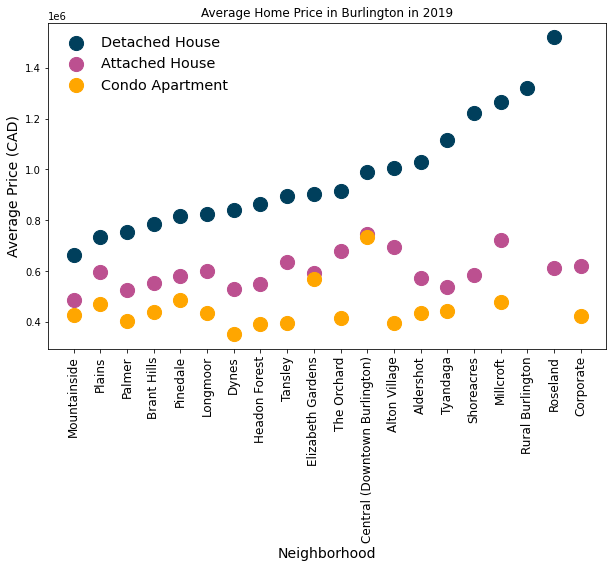

In [41]:
Color_List = ['#003f5c', '#bc5090', '#ffa600']


ax0 = HousePrice_sorted.plot(kind='scatter',
                    x='Neighborhood',
                    y='Average Detached House Price',
                    figsize=(10, 6),
                    color=Color_List[0],  
                    s=200                 
                    )


ax1 = HousePrice_sorted.plot(kind='scatter',
                    x='Neighborhood',
                    y='Average Attached House Price',
                    color=Color_List[1],                 
                    ax = ax0,
                    s=200                 
                   )

ax2 = HousePrice_sorted.plot(kind='scatter',
                    x='Neighborhood',
                    y='Average Condo Apartment Price',
                    color=Color_List[2],
                    ax = ax0,
                    s=200                 
                   )

ax0.set_ylabel('Average Price (CAD)', fontsize=14)
ax0.set_xlabel('Neighborhood', fontsize=14)
ax0.set_title('Average Home Price in Burlington in 2019')
ax0.legend(['Detached House', 'Attached House', 'Condo Apartment'], loc='upper left', fontsize='x-large', frameon=False)
plt.xticks(rotation=90, fontsize=12)

### Handling the Missing Data <a name="4.2"></a>
An estimate for the Average Attached House Price for the "Corporate" neighborhood is needed for the clustering. Because the average price of detached houses and condo apartments do not follow the same trend as the average price for detached houses, they can not be used for the estimation of the missing data. Therefore, the average of the average detached house price for the other 19 neighboroods is used as the estimate for the 'Corporate' neighborhood. 

In [42]:
HousePrice_sorted.describe()

,Average Detached House Price,Average Attached House Price,Average Condo Apartment Price
count,1.900000e+01,19.000000,17.000000
mean,9.714306e+05,600411.315789,452147.647059
std,2.257162e+05,69801.038582,87003.707108
min,6.612950e+05,483861.000000,352073.000000
25%,8.205455e+05,549743.000000,403439.000000
50%,9.042350e+05,592210.000000,434500.000000
75%,1.072753e+06,626992.500000,470178.000000
max,1.519006e+06,744875.000000,733829.000000


In [43]:
df_House = HousePrice_sorted.set_index('Neighborhood')
df_House

,Average Detached House Price,Average Attached House Price,Average Condo Apartment Price
Neighborhood,,,
Mountainside,661295.0,483861.0,428237.0
Plains,735543.0,597244.0,470178.0
Palmer,752409.0,523383.0,403439.0
Brant Hills,786025.0,551008.0,438629.0
Pinedale,814903.0,581251.0,485637.0
Longmoor,826188.0,598186.0,434500.0
Dynes,838450.0,530461.0,352073.0
Headon Forest,864441.0,548478.0,390058.0
Tansley,896590.0,636032.0,394004.0


In [44]:
df_House.at['Corporate', 'Average Detached House Price']=  904235
df_House

,Average Detached House Price,Average Attached House Price,Average Condo Apartment Price
Neighborhood,,,
Mountainside,661295.0,483861.0,428237.0
Plains,735543.0,597244.0,470178.0
Palmer,752409.0,523383.0,403439.0
Brant Hills,786025.0,551008.0,438629.0
Pinedale,814903.0,581251.0,485637.0
Longmoor,826188.0,598186.0,434500.0
Dynes,838450.0,530461.0,352073.0
Headon Forest,864441.0,548478.0,390058.0
Tansley,896590.0,636032.0,394004.0


<a id='item4'></a>
## 4. Parks <a name="5"></a>

The objective of this section is to search the parks, playgrounds and, sports fields of each neighborhood in Burlington, using the FourSquare API. This API can search the venues in a specific radius from a specific coordinates location. In order to cover more venues, some neighborhoods are split into subsets. However, the data for each neighborhood will be merged later. 

### Locations and API Credentials <a name="5.1"></a>

In [45]:
Neighborhood_Locations = pd.read_excel('Neighborhoods_Split.xlsx')
Neighborhood_Locations

,Neighborhood,Latitude,Longitude,Radius
0,Aldershot,43.312147,-79.859771,2000
1,Alton Village_1,43.399696,-79.824503,500
2,Alton Village_2,43.406566,-79.818026,500
3,Alton Village_3,43.415448,-79.809557,500
4,Alton Village_4,43.420958,-79.802243,500
5,Brant Hills,43.366230,-79.839933,1000
6,Dynes,43.352015,-79.786079,1000
7,Elizabeth Gardens_1,43.367845,-79.743761,500
8,Elizabeth Gardens_2,43.372371,-79.735034,500
9,Headon Forest,43.378287,-79.822473,1000


In [46]:
CLIENT_ID = 'Enter Your CIENT_ID' # your Foursquare ID
CLIENT_SECRET = 'Enter Your CLIENT_SECRET' # your Foursquare Secret
VERSION = 'Enter the VERSION' # Foursquare API version



#### Choice of data 

In this section 3 different data sets obtained from 3 different search radius are examined. The default search radius was set to 1000 meters, estimated from the map of Burlington. If the search radius is slightly increased, more areas are covered, meaning that more venues are found. However, mover overlaps would happen and more specific venues will be assigned to more than one neighbouhoods.

#### Setting 1 (R=1000 m)

In [47]:
LIMIT = 100
query_list=['Park', 'Play']
venues_list_1=[]

for query in query_list:
    for neighborhood, lat, lng, radius in zip(Neighborhood_Locations['Neighborhood'], Neighborhood_Locations['Latitude'], Neighborhood_Locations['Longitude'], Neighborhood_Locations['Radius']):
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, lat, lng, VERSION, query, radius, LIMIT)
        results = requests.get(url).json()['response']['venues']
        for v in results:
            try:
                Venue_Category = v['categories'][0]['name']
            except:
                Venue_Category = np.isnan
            venues_list_1.append([neighborhood, v['name'], v['location']['lat'], v['location']['lng'], Venue_Category])

In [48]:
Venues_1 = pd.DataFrame(venues_list_1)
Venues_1.columns = ['Neighborhood', 'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']

In [49]:
import operator

for Neighborhood in Venues_1['Neighborhood']:
    if operator.contains(Neighborhood, '_'):
        Neighborhood_new = Neighborhood.split('_')[0]
        Venues_1.replace(Neighborhood, Neighborhood_new, inplace=True)

We are interested in some specific venues only. We need to exclude the rest.

In [50]:
Filter_List=['Park', 'Playground', 'Soccer Field', 'Baseball Field', np.isnan] 
Venues_Park_1 = Venues_1.loc[Venues_1['Venue Category'].isin(Filter_List)]
Total_1 = Venues_Park_1.shape[0]
Total_1 

97

In [51]:
Duplicates_1= Venues_Park_1[Venues_Park_1.duplicated(['Venue','Venue Latitude', 'Venue Longitude'], keep=False)].shape[0]
Duplicates_1

12

#### Setting 2 (R=1100 m)

In [52]:
LIMIT = 100
query_list=['Park', 'Play']
venues_list_2=[]

for query in query_list:
    for neighborhood, lat, lng, radius in zip(Neighborhood_Locations['Neighborhood'], Neighborhood_Locations['Latitude'], Neighborhood_Locations['Longitude'], (Neighborhood_Locations['Radius']*1.1)):
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, lat, lng, VERSION, query, radius, LIMIT)
        results = requests.get(url).json()['response']['venues']
        for v in results:
            try:
                Venue_Category = v['categories'][0]['name']
            except:
                Venue_Category = np.isnan
            venues_list_2.append([neighborhood, v['name'], v['location']['lat'], v['location']['lng'], Venue_Category])

In [53]:
Filter_List=['Park', 'Playground', 'Soccer Field', 'Baseball Field', np.isnan] 
Venues_2 = pd.DataFrame(venues_list_2)
Venues_2.columns = ['Neighborhood', 'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']

In [54]:
import operator 

for Neighborhood in Venues_2['Neighborhood']:
    if operator.contains(Neighborhood, '_'):
        Neighborhood_new = Neighborhood.split('_')[0]
        Venues_2.replace(Neighborhood, Neighborhood_new, inplace=True)

In [55]:
Venues_Park_2 = Venues_2.loc[Venues_2['Venue Category'].isin(Filter_List)]
Total_2 = Venues_Park_2.shape[0]


In [56]:
Duplicates_2= Venues_Park_2[Venues_Park_2.duplicated(['Venue','Venue Latitude', 'Venue Longitude'], keep=False)].shape[0]

#### Setting 3 (R=1200m)

In [57]:
LIMIT = 100
query_list=['Park', 'Play']
venues_list_3=[]

for query in query_list:
    for neighborhood, lat, lng, radius in zip(Neighborhood_Locations['Neighborhood'], Neighborhood_Locations['Latitude'], Neighborhood_Locations['Longitude'], (Neighborhood_Locations['Radius']*1.2)):
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, lat, lng, VERSION, query, radius, LIMIT)
        results = requests.get(url).json()['response']['venues']
        for v in results:
            try:
                Venue_Category = v['categories'][0]['name']
            except:
                Venue_Category = np.isnan
            venues_list_3.append([neighborhood, v['name'], v['location']['lat'], v['location']['lng'], Venue_Category])

In [58]:
Venues_3 = pd.DataFrame(venues_list_3)
Venues_3.columns = ['Neighborhood', 'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']

In [59]:
for Neighborhood in Venues_3['Neighborhood']:
    if operator.contains(Neighborhood, '_'):
        Neighborhood_new = Neighborhood.split('_')[0]
        Venues_3.replace(Neighborhood, Neighborhood_new, inplace=True)

In [60]:
Venues_Park_3= Venues_3.loc[Venues_3['Venue Category'].isin(Filter_List)]
Total_3 = Venues_Park_3.shape[0]

In [61]:
Duplicates_3= Venues_Park_3[Venues_Park_3.duplicated(['Venue','Venue Latitude', 'Venue Longitude'], keep=False)].shape[0]

#### Choice of setting

In [62]:
Settings_df = pd.DataFrame({
              'Radius ( XR)': [1, 1.1, 1.2],
              'Number of Venues': [Total_1, Total_2, Total_3],
              'Number of Duplicates': [Duplicates_1, Duplicates_2, Duplicates_3],
              'Number of Unique Venues': [Total_1-round(Duplicates_1/2), Total_2-round(Duplicates_2/2), Total_3-round(Duplicates_3/2)],
               }, index=['Setting_1', 'Setting_2', 'Setting_3'])

Settings_df

,Radius ( XR),Number of Venues,Number of Duplicates,Number of Unique Venues
Setting_1,1.0,97,12,91
Setting_2,1.1,118,33,102
Setting_3,1.2,131,50,106


Setting 2 finds 11 more unique venues compared to setting 1. Setting 3 finds only 4 more venues, but there are many more duplicates to handle! I choose Setting 2. 

#### Handling the Duplicates 

In [63]:
Venues_Park_2[Venues_Park_2.duplicated(['Venue','Venue Latitude', 'Venue Longitude'], keep=False)]

,Neighborhood,Venue,Venue Latitude,Venue Longitude,Venue Category
13,Alton Village,Palladium park,43.399917,-79.829157,Park
14,Alton Village,Norton Community Park,43.398966,-79.817798,Park
15,Alton Village,Berton Park,43.395363,-79.819317,Park
17,Alton Village,Doug Wright Park,43.405763,-79.821451,Playground
18,Alton Village,Zimmerman Park,43.405760,-79.821441,Park
25,Brant Hills,Champlain Park,43.366221,-79.826701,Playground
26,Brant Hills,Cavendish Park,43.356922,-79.839114,Baseball Field
27,Brant Hills,Fairchild park,43.355990,-79.843180,Park
37,Elizabeth Gardens,Mohawk Park,43.369849,-79.738320,Playground
38,Elizabeth Gardens,Mohawk Park,43.369849,-79.738320,Playground


In [64]:
#to be droppped

ToBeDropped_Dict={'Alton Village': 'Berton Park', 'Millcroft': 'Norton Community Park', 'Rural Burlington': 'Berton Park', 'Rural Burlington': 'Palladium park', 'Rural Burlington': 'Doug Wright Park', 'Headon Forest': 'Champlain Park', 'Tyandaga': 'Cavendish Park', 'Brant Hills': 'Fairchild park', 'Elizabeth Gardens': 'Mohawk Park', 'Millcroft': 'Dryden Parkette', 'Central': 'Tom Tompson Park', 'Plains': 'Tom Tompson Park', 'Central': 'George Bolus Park', 'Plains': 'George Bolus Park'}

In [65]:
Parks = Venues_Park_2.drop(index=[15,18,27,37,45,52,56,60,85,86,101,122,128,140,146,148,157,158,159,166,170])

In [66]:
Parks[Parks.duplicated(['Venue','Venue Latitude', 'Venue Longitude'], keep=False)]

,Neighborhood,Venue,Venue Latitude,Venue Longitude,Venue Category


In [67]:
Parks.loc[Parks['Venue']=='Cavendish Park'] = Parks.loc[Parks['Venue']=='Cavendish Park'].replace('Brant Hills', 'Mountainside')

In [68]:
Parks.reset_index(drop=True, inplace=True)

In [69]:
Parks

,Neighborhood,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Aldershot,LaSalle Park,43.300853,-79.845929,Park
1,Aldershot,Hidden Valley Park,43.303402,-79.862750,Playground
2,Aldershot,Aldershot Park,43.314603,-79.845890,<ufunc 'isnan'>
3,Aldershot,Holy Rosary Ball Diamond & Park,43.313680,-79.844771,Baseball Field
4,Aldershot,Bayshore Park,43.306530,-79.837440,<ufunc 'isnan'>
5,Aldershot,BCA Park,43.327104,-79.846128,Playground
6,Aldershot,Kiwanis Park,43.316240,-79.833189,Park
7,Aldershot,Fairfield Parkette,43.295710,-79.863594,Playground
8,Alton Village,Palladium park,43.399917,-79.829157,Park
9,Alton Village,Norton Community Park,43.398966,-79.817798,Park


In [70]:
#correct the location of Zimmerman Park
Parks.iloc[90,2] = float(43.427178)
Parks.iloc[90,3] = float(-79.852459)

In [71]:
To_be_dropped=['Parkway drive, burlington', 'E.A. Washburn Memorial Park Resevoir', 'Amazing Adventures Playland', 'Mountainside Park', 'Mount Forest Park', 'Roly Bird Dog Park', 'Carlisle Memorial Park', 'Mountain Gardens Parkette', "Spencer's Splash Pad & Park", ]
Parks = Parks.loc[~Parks['Venue'].isin(To_be_dropped)]

In [72]:
Parks=Parks.reset_index(drop=True) 


In [73]:
Parks.groupby(by='Neighborhood').count()

,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,
Aldershot,8,8,8,8
Alton Village,3,3,3,3
Brant Hills,5,5,5,5
Central,12,12,12,12
Corporate,3,3,3,3
Dynes,3,3,3,3
Elizabeth Gardens,2,2,2,2
Headon Forest,4,4,4,4
Longmoor,3,3,3,3


In [74]:
Parks.sort_values(by='Neighborhood')

,Neighborhood,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Aldershot,LaSalle Park,43.300853,-79.845929,Park
1,Aldershot,Hidden Valley Park,43.303402,-79.862750,Playground
2,Aldershot,Aldershot Park,43.314603,-79.845890,<ufunc 'isnan'>
3,Aldershot,Holy Rosary Ball Diamond & Park,43.313680,-79.844771,Baseball Field
4,Aldershot,Bayshore Park,43.306530,-79.837440,<ufunc 'isnan'>
5,Aldershot,BCA Park,43.327104,-79.846128,Playground
6,Aldershot,Kiwanis Park,43.316240,-79.833189,Park
7,Aldershot,Fairfield Parkette,43.295710,-79.863594,Playground
8,Alton Village,Palladium park,43.399917,-79.829157,Park
9,Alton Village,Norton Community Park,43.398966,-79.817798,Park


### Map 

In [75]:
# Burlington Location
latitude = 43.35
longitude = -79.7990

# create map
map_Parks = folium.Map(location=[latitude, longitude], zoom_start=12)

#set color scheme for neighborhoods
x = np.arange(len(set(Parks['Neighborhood'])))
ys = [i + x + (i*x)**2 for i in range(len(list(set(Parks['Neighborhood']))))]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]


# add markers to the map
markers_colors = []
for lat, lon, name, neighborhood, color_code in zip(Parks['Venue Latitude'], Parks['Venue Longitude'], Parks['Venue'], Parks['Neighborhood'], Parks['Neighborhood'].factorize()[0]):
    label = folium.Popup(str(name)+'\n'+'('+str(neighborhood)+')', parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=7,
        popup=label,
        color = rainbow[color_code-1],
        fill=True,
        fill_color=rainbow[color_code-1],
        fill_opacity=0.7).add_to(map_Parks)
       
map_Parks

<a id='item5'></a>
## 5. Clustering the Neighborhoods

In [76]:
df1 = Neighborhoods.set_index('Neighborhood')

In [78]:
df2 = School_Rating[['(Average_Score)X(min_Score)']]
df3 = df_House[['Average Detached House Price']].astype('int')


In [79]:
df_merged = pd.merge(df2, df3, on='Neighborhood')
df_merged

,(Average_Score)X(min_Score),Average Detached House Price
Neighborhood,,
Aldershot,24.60,1028633
Alton Village,58.46,1004791
Brant Hills,21.83,786025
Central (Downtown Burlington),39.65,988647
Corporate,40.60,904235
Dynes,30.87,838450
Elizabeth Gardens,28.60,904235
Headon Forest,42.60,864441
Longmoor,29.82,826188


In [80]:
from sklearn.preprocessing import StandardScaler
X = df_merged.values
Clus_dataSet = StandardScaler().fit_transform(X)
Clus_dataSet

array([[-1.52466812,  0.28216581],
       [ 2.40090883,  0.17108337],
       [-1.84580953, -0.848171  ],
       [ 0.22016157,  0.09586673],
       [ 0.33030032, -0.29741787],
       [-0.79775236, -0.60391727],
       [-1.06092601, -0.29741787],
       [ 0.56217137, -0.4828224 ],
       [-0.91948467, -0.66104725],
       [ 1.44907815,  1.3772192 ],
       [ 0.28392611, -1.4293015 ],
       [ 0.21436479, -1.00479156],
       [ 0.5899959 , -0.71362528],
       [-0.79775236, -1.08337207],
       [ 1.10127157,  2.56686645],
       [-0.29575153,  1.63565059],
       [-0.70384459,  1.18327452],
       [ 0.35348742, -0.33303675],
       [ 0.53202813, -0.25049134],
       [-0.091705  ,  0.69328548]])

In [81]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Clus_dataSet)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([2, 3, 2, 0, 0, 2, 2, 0, 2, 3, 0, 0, 0, 2, 3, 1, 1, 0, 0, 1])

In [82]:
df_merged.insert(0, 'Cluster Labels', kmeans.labels_)

In [83]:
df_merged.sort_values('Cluster Labels')

,Cluster Labels,(Average_Score)X(min_Score),Average Detached House Price
Neighborhood,,,
Tansley,0,40.80,896590
Central (Downtown Burlington),0,39.65,988647
Corporate,0,40.60,904235
Headon Forest,0,42.60,864441
Pinedale,0,42.84,814903
The Orchard,0,42.34,914307
Mountainside,0,40.20,661295
Palmer,0,39.60,752409
Tyandaga,1,36.96,1116873


In [84]:
df_merged.groupby('Cluster Labels').mean()

,(Average_Score)X(min_Score),Average Detached House Price
Cluster Labels,,
0,41.078750,8.496034e+05
1,34.613333,1.219350e+06
2,27.765000,8.531790e+05
3,51.986667,1.262488e+06


In [86]:
Burlington_School_House = pd.merge(pd.merge(School_Rating[['Average FI Score','Maximum FI Score', 'Minimum FI Score']], df_merged[['Average Detached House Price', 'Cluster Labels']], on='Neighborhood'), Neighborhoods.set_index('Neighborhood'), on='Neighborhood')

In [87]:
Burlington_School_House

,Average FI Score,Maximum FI Score,Minimum FI Score,Average Detached House Price,Cluster Labels,Latitude,Longitude
Neighborhood,,,,,,,
Aldershot,6.0,7.0,4.1,1028633,2,43.312147,-79.859771
Alton Village,7.9,8.7,7.4,1004791,3,43.408200,-79.814130
Brant Hills,5.9,8.1,3.7,786025,2,43.366230,-79.839933
Central (Downtown Burlington),6.5,7.2,6.1,988647,0,43.332110,-79.805382
Corporate,7.0,7.6,5.8,904235,0,43.394038,-79.773862
Dynes,6.3,7.3,4.9,838450,2,43.352015,-79.786079
Elizabeth Gardens,6.5,7.7,4.4,904235,2,43.369097,-79.739184
Headon Forest,7.1,7.8,6.0,864441,0,43.378287,-79.822473
Longmoor,7.1,8.8,4.2,826188,2,43.366607,-79.770717


In [88]:
Clusters_Mean = Burlington_School_House[['Average FI Score', 'Maximum FI Score',
       'Minimum FI Score', 'Average Detached House Price', 'Cluster Labels']].groupby('Cluster Labels').mean()

In [89]:
Clusters_Mean

,Average FI Score,Maximum FI Score,Minimum FI Score,Average Detached House Price
Cluster Labels,,,,
0,6.850000,7.687500,6.000000,8.496034e+05
1,6.733333,8.100000,5.166667,1.219350e+06
2,6.350000,7.683333,4.366667,8.531790e+05
3,7.633333,8.533333,6.800000,1.262488e+06


In [90]:
df_House_Clustered = pd.merge(df_House, df_merged[['Cluster Labels']], on='Neighborhood')

In [91]:
df_House_Clustered.head()

,Average Detached House Price,Average Attached House Price,Average Condo Apartment Price,Cluster Labels
Neighborhood,,,,
Mountainside,661295.0,483861.0,428237.0,0
Plains,735543.0,597244.0,470178.0,2
Palmer,752409.0,523383.0,403439.0,0
Brant Hills,786025.0,551008.0,438629.0,2
Pinedale,814903.0,581251.0,485637.0,0


In [92]:
HouseClusters_Mean = df_House_Clustered[['Average Detached House Price', 'Average Attached House Price', 'Average Condo Apartment Price', 'Cluster Labels']].groupby('Cluster Labels').mean()

In [93]:
HouseClusters_Mean

,Average Detached House Price,Average Attached House Price,Average Condo Apartment Price
Cluster Labels,,,
0,8.496034e+05,601652.750000,458885.375
1,1.219350e+06,560981.500000,444167.000
2,8.531790e+05,573667.166667,449817.000
3,1.262488e+06,676875.666667,436179.000


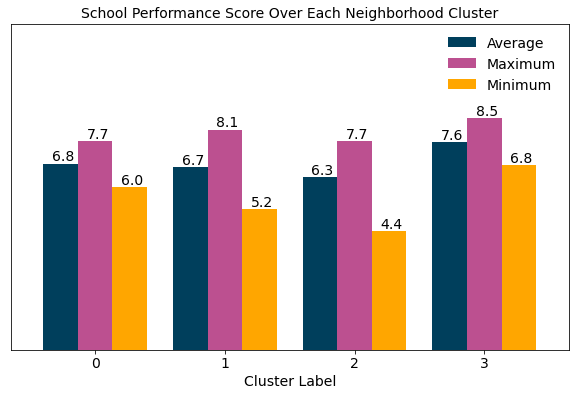

In [94]:
Color_List = ['#003f5c', '#bc5090', '#ffa600']
ax = Clusters_Mean[['Average FI Score', 'Maximum FI Score', 'Minimum FI Score']].plot(kind='bar', color=Color_List, figsize=(10,6), width = 0.8)
ax.set_title("School Performance Score Over Each Neighborhood Cluster", fontsize=14)

ax.tick_params(labelsize=14, rotation=0)
ax.legend(['Average', 'Maximum', 'Minimum'], fontsize=14, frameon=False)
#ax.spines["top"].set_visible(False)
#ax.spines["right"].set_visible(False)
#ax.spines["left"].set_visible(False)
ax.set_yticks([])
ax.set_ylim(0,12)
ax.set_xlabel('Cluster Label', fontsize=14)
#ax.set_xticklabels(Clusters_Mean['Cluster Labels'], Rotation=0 ) 



# set individual bar lables using above list
#for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
 #   ax.text(i.get_x(), i.get_height()+1, \
  #          str(round((i.get_height()/total)*100, 2))+'%', fontsize=14,
   #             color='black')

for i in ax.patches:
    y=i.get_height()
    x=i.get_x()+i.get_width()/2
    label = "{:.2}".format(y)
    ax.annotate(label, xy=(x+0.02,y+0.1), ha='center', fontsize=14)

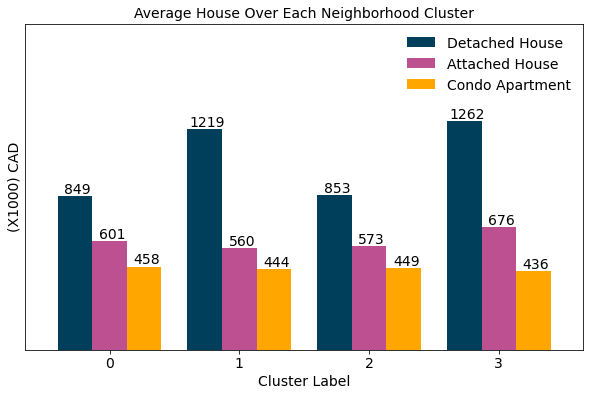

In [95]:
Color_List = ['#003f5c', '#bc5090', '#ffa600']
ax = HouseClusters_Mean[['Average Detached House Price', 'Average Attached House Price', 'Average Condo Apartment Price']].plot(kind='bar', color=Color_List, figsize=(10,6), width = 0.8)
ax.set_title("Average House Over Each Neighborhood Cluster", fontsize=14)

ax.tick_params(labelsize=14, rotation=0)
ax.legend(['Detached House', 'Attached House', 'Condo Apartment'],fontsize=14, frameon=False)
#ax.spines["top"].set_visible(False)
#ax.spines["right"].set_visible(False)
#ax.spines["left"].set_visible(False)
ax.set_yticks([])
ax.set_ylim(0,1800000)
ax.set_xlabel('Cluster Label', fontsize=14)
#ax.set_xticklabels(Clusters_Mean['Cluster Labels'], Rotation=0 ) 
ax.set_ylabel('(X1000) CAD', fontsize=14)


# set individual bar lables using above list
#for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
 #   ax.text(i.get_x(), i.get_height()+1, \
  #          str(round((i.get_height()/total)*100, 2))+'%', fontsize=14,
   #             color='black')

for i in ax.patches:
    y=i.get_height()
    x=i.get_x()+i.get_width()/2
    label = int(y/1000)
#    label = "{:.2}".format(y)
    ax.annotate(label, xy=(x+0.02,y+15000), ha='center', fontsize=14, rotation=0)

In [96]:
# Burlington Location
latitude = 43.35
longitude = -79.7990

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
#x = np.arange(kclusters)
#ys = [i + x + (i*x)**2 for i in range(kclusters)]
#colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
#rainbow = [colors.rgb2hex(i) for i in colors_array]
ColorList=['blue', 'red', 'green', 'Purple']

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Burlington_School_House['Latitude'], Burlington_School_House['Longitude'], Burlington_School_House.index, Burlington_School_House['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=7,
        popup=label,
        color = ColorList[cluster-1],
        fill=True,
        fill_color=ColorList[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters